In [1]:
from attr import asdict
import matplotlib.pyplot as plt
import numpy as np

from model.sticky_hdp_hmm_var import sticky_hdp_hmm_var
from parameters import TrainingParams, SamplingParams
from utils.data_preparation import generate_data_structure

In [2]:
def r_2(y, pred_y):
    """
     Return the coefficient of determination for each dimension
    :param y:
    :param pred_y:
    :return:
    """
    MSE = ((y - pred_y)**2).sum(axis=1)
    mean_y = np.mean(y, axis=1)[:, np.newaxis]
    return 1 - MSE / ((y - mean_y)**2).sum(axis=1)

def generate_sine_wave(f_s, T, switch_count):
    """
    Generate a sequence using a combination of time invariant sine waves with
    the following state space representation: 
        [sin[w(t+1)]] = [2cos(x), -1][ sin[w(t)] ]
        [ sin[w(t)] ] = [   1   ,  0][sin[w(t-1)]]
        where x = 2*pi*f  
    @param int T: number of time points
    @param list(float) f_s: list containing the frequencies of each sine wave
    @param int switch_count: number of switches to do between sine waves                                     
    """
    A = dict()
    for i in range(len(f_s)):
        A[i] = np.array([[2*np.cos(2*np.pi*f_s[i]), -1.0], [1.0, 0.0]])
    Y = np.zeros((2, T))
    Y[:, 0] = np.array([-1.0, 0.0])
    switched_1 = True
    # switch indices 
    switch_inds = [int(ind) for ind in np.linspace(int(T / (switch_count + 1)), T, switch_count+ 1)]
    mode_ind = 0
    for t in range(1, T):
        if t in switch_inds:
            mode_ind += 1
            if mode_ind > len(f_s) - 1:
                mode_ind = 0
        Y[:, t] = A[mode_ind] @ Y[:, t-1]
    return Y, A


# Load Sine Wave Data

# Generate & Plot Sine Wave

0: A = [[ 1.99901312 -1.        ]
 [ 1.          0.        ]]
1: A = [[ 1.78201305 -1.        ]
 [ 1.          0.        ]]


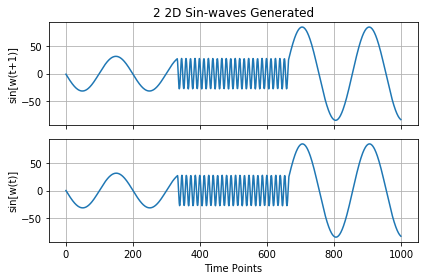

In [3]:
T = 1000
f_s = [0.005, 0.075]
switch_count = 2

Y, A = generate_sine_wave(f_s, T, switch_count)
sin_data = {'Y': Y}

x = np.arange(T) 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.set_title(f'{len(f_s)} 2D Sin-waves Generated')
ax1.plot(x, sin_data['Y'][0])
ax1.grid()
ax1.set_ylabel('sin[w(t+1)]')
ax2.plot(x, sin_data['Y'][1])
plt.xlabel('Time Points')
ax2.grid()
ax2.set_ylabel('sin[w(t)]')
plt.tight_layout()
for i in range(len(f_s)):
    print(f"{i}: A = {A[i]}")

# Train Model

## Params

In [8]:
L = 6
order = 1
D = sin_data['Y'].shape[0]

tr = asdict(TrainingParams(iterations=500, sample_every=10, burn_in=50, print_every=100))
s_params = asdict(SamplingParams(S_0=0.000001*np.eye(D),K=np.linalg.inv(np.diag(10000.0 * np.ones(D * order)))))

## Generate Data Structure

In [9]:
train_data = generate_data_structure(sin_data['Y'], order)

## Training Model

In [10]:
model = sticky_hdp_hmm_var(D, L, order)
model.set_training_parameters(tr)
model.set_sampling_parameters(s_params)
model.train(train_data)

Iteration: 100/500
Sequence log-likelihood: 7733971.4433097225
Iteration: 200/500
Sequence log-likelihood: 7745650.05717539
Iteration: 300/500
Sequence log-likelihood: 7719018.53417079
Iteration: 400/500
Sequence log-likelihood: 7704088.57747086
Iteration: 500/500
Sequence log-likelihood: 7750979.350456376
Training has stopped at iteration: 500


# Evaluate Results

In [11]:
state_sequence = model.predict_state_sequence(train_data)

## Predict Y

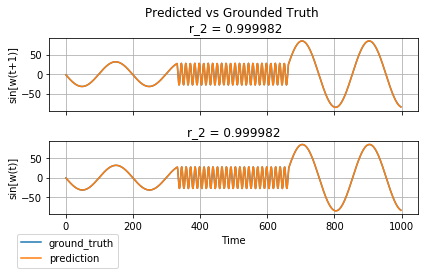

In [63]:
pred_Y = model.predict_observations(X_0=train_data['X'], reset_every=None)
r = r_2(pred_Y, train_data['Y'])
x = np.arange(train_data['Y'].shape[1]) 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.set_title(f'Predicted vs Grounded Truth \n r_2 = {r[0]:.6f}')
ax1.plot(x, train_data['Y'][0], label='ground_truth')
ax1.plot(x, pred_Y[0], label='prediction')
ax1.grid()
ax1.set_ylabel('sin[w(t+1)]')
ax2.plot(x, train_data['Y'][1], label='ground_truth')
ax2.plot(x, pred_Y[1], label='prediction')
ax2.set_title(f'r_2 = {r[1]:.6f}')
plt.xlabel('Time')
ax2.grid()
ax2.set_ylabel('sin[w(t)]')
plt.legend(bbox_to_anchor=(0.2, -0.2))
plt.tight_layout()

## Compare A-matrices

In [13]:
_, state_inds =  np.unique(state_sequence, return_index=True)
for i, k in enumerate(state_sequence[np.sort(state_inds)]):
    print('*********************************')
    print('Ground Truth A Matrix')
    print(A[i])
    print(f"Model's Predicted A Matrix")
    print(model.theta['A'][:, :, k])

*********************************
Ground Truth A Matrix
[[ 1.99901312 -1.        ]
 [ 1.          0.        ]]
Model's Predicted A Matrix
[[ 1.99904030e+00 -1.00002735e+00]
 [ 1.00000470e+00 -4.78074475e-06]]
*********************************
Ground Truth A Matrix
[[ 1.78201305 -1.        ]
 [ 1.          0.        ]]
Model's Predicted A Matrix
[[ 1.78200809e+00 -9.99994178e-01]
 [ 9.99999055e-01  3.04143124e-06]]
